This notebook is where I run tests or prepare the datasets.

In [1]:
import data_prep
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor()

print(executor._max_workers)

28


# Get datasets differentiated by category

In [10]:
df = pd.read_csv(f'datasets/m4_info.csv')
df

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


In [43]:
m4_daily_finance_ind = []

for entry in df.values:
    if 'D' in entry[0] and entry[1] == 'Finance':
        ind = entry[0][1:]
        m4_daily_finance_ind.append(int(ind))

In [44]:
len(m4_daily_finance_ind)

1559

In [45]:
with open(f'datasets/m4_daily_dataset.json') as file:
    m4_daily = json.load(file)


In [46]:
m4_daily_finance_ind

[2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 2080,
 2081,
 2082,
 2083,
 2084,
 2085,
 2086,
 2087,
 2088,
 2089,
 2090,
 2091,
 2092,
 2093,
 2094,
 2095,
 2096,
 2097,
 2098,
 2099,
 2100,
 2101,
 2102,
 2103,
 2104,
 2105,
 2106,
 2107,
 2108,
 2109,
 2110,
 2111,
 2112,
 2113,
 2114,
 2115,
 2116,
 2117,
 2118,
 2119,
 2120,
 2121,
 2122,
 2123,
 2124,
 2125,
 2126,
 2127,
 2128,
 2129,
 2130,
 2131,
 2132,
 2133,
 2134,
 2135,
 2136,
 2137,
 2138,
 2139,
 2140,
 2141,
 2142,
 2143,
 2144,
 2145,
 2146,
 2147,
 2148,
 2149,
 2150,
 2151,
 2152,
 2153,
 2154,
 2155,
 2156,
 2157,
 2158,
 2159,
 2160,
 2161,
 2162,
 2163,
 2164,
 2165,
 2166,
 2167,
 2168,
 2169,
 2170,
 2171,
 2172,
 2173,
 2174,
 2175,
 2176,
 2177,
 2178,

In [47]:
m4_daily_finance = {
    k: m4_daily[str(k)] for k in m4_daily_finance_ind
}

In [68]:
print(list(m4_daily_finance.keys()))

[2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 220

In [108]:
min_len = 500

sub = {i: (k, m4_daily_finance[k]) for i, k in enumerate(m4_daily_finance.keys()) if len(m4_daily_finance[k]) >= 500}

len(sub)

1405

In [128]:
min_len = 1000
max_len = 1500
lens= []
count = 0
pick = 50
sub = {}
for k, v in m4_daily_finance.items():
    if count > pick: break
    l = len(v)
    if l >= min_len and l <= max_len:
        sub[k] = v
        lens.append(l)
        count += 1

print(np.mean(lens))

1222.9607843137255


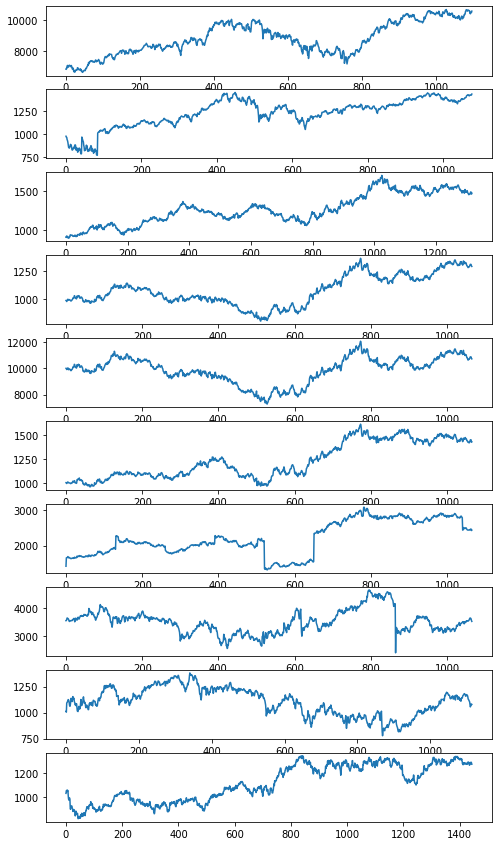

In [140]:

seg = 4

fig, axs = plt.subplots(nrows=10, ncols = 1, figsize = (8, 15))

for i, k in enumerate(sub.keys()):
    flag = (seg * 10, (seg+1)*10)
    if i >= flag[0] and i < flag[1]:
        axs[i-seg*10].plot(sub[k])

plt.show()

In [49]:
with open(f'datasets/m4_daily_finance.json', 'x') as file:
    json.dump(m4_daily_finance, file)

In [50]:
with open(f'datasets/m4_hourly_dataset.json') as file:
    d = json.load(file)

min_len = 500
max_len = 9999
count = 0

for k, v in d.items():
    if len(v) < min_len:
        count += 1

print(count)

0


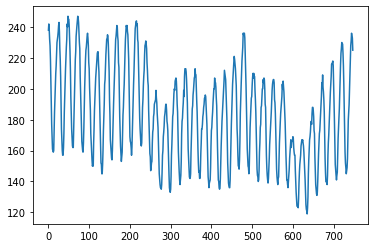

In [64]:
plt.plot(d['13'])
plt.show()

In [2]:
# generator function that creates equal chunk size of index range of the tasks
def split(tasks, n_chunk):
    p, q = divmod(len(tasks), n_chunk)
    return (tasks[i*p + min(i, q):(i+1)*p + min(i+1, q)] for i in range(n_chunk))

list(split(range(15),3))

[range(0, 5), range(5, 10), range(10, 15)]

In [3]:
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
start = now.strftime("%d-%m-%Y %H:%M:%S")
print(start)

30-06-2022 13:59:16


In [9]:
from sklearn.svm import LinearSVR

ls = d['0']

ls_x, ls_y = data_prep.ts_prep(ls, nlag=10, horizon=1)

svr = LinearSVR()
svr.fit(ls_x[:-3], ls_y[:-3].ravel())
svr.predict([ls_x[-1]])[0]

/home/yukuan.lin/Desktop/DCTransformation/dclab01/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


667.7644846035547

# M4 Hourly dataset

In [3]:
df, frequency, forecast_horizon, missing_values, equal_len = data_prep.convert_tsf_to_dataframe('datasets/m4_hourly_dataset.tsf')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/m4_hourly_dataset.tsf'

In [4]:
print(len(df), frequency, forecast_horizon, missing_values, equal_len)

414 hourly 48 False False


In [5]:
arr = df.values
arr = arr.T
d = {i: list(a) for i, a in enumerate(arr[2])}

lens = []
min_len = 1000
for k, v in d.items():
    l = len(v)
    if l >= min_len:
        lens.append(l)

print(len(lens), np.mean(lens))

245 1008.0


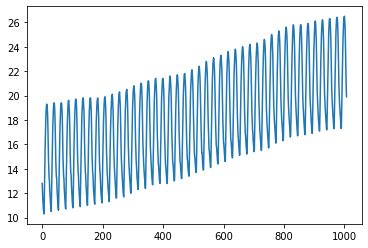

In [6]:
plt.plot(d[169])
plt.show()

In [5]:
import json

with open(f'datasets/m4_hourly_dataset.json', 'r') as file:
    json.dump(d, file)

NameError: name 'd' is not defined

# M4 Daily dataset

In [16]:
df, frequency, forecast_horizon, missing_values, equal_len = data_prep.convert_tsf_to_dataframe('datasets/m4_daily_dataset.tsf')
df.head()

,series_name,start_timestamp,series_value
0,T1,1994-01-03 12:00:00,"[1017.1, 1019.3, 1017.0, 1019.2, 1018.7, 1015...."
1,T2,1995-01-02 12:00:00,"[2793.7, 2793.8, 2803.7, 2805.8, 2802.3, 2795...."
2,T3,2006-01-05 12:00:00,"[1091.3, 1088.5, 1085.7, 1082.9, 1080.1, 1077...."
3,T4,1996-05-30 12:00:00,"[1092.0, 1078.0, 1064.0, 1050.0, 1036.0, 1022...."
4,T5,1997-01-03 12:00:00,"[2938.63, 2956.44, 2964.41, 2972.41, 3014.97, ..."


In [17]:
print(len(df), frequency, forecast_horizon, missing_values, equal_len)

4227 daily 14 False False


In [18]:
arr = df.values
arr = arr.T
d = {i: list(a) for i, a in enumerate(arr[2])}

lens = []
min_len = 1000
for k, v in d.items():
    l = len(v)
    if l >= min_len:
        lens.append(l)

print(len(lens), np.mean(lens))

2663 3554.542996620353


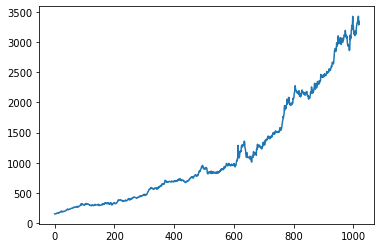

In [19]:
plt.plot(d[5])
plt.show()

In [20]:
import json

with open(f'datasets/m4_daily_dataset.json', 'x') as file:
    json.dump(d, file)

# M4 Weekly dataset

In [4]:
df, frequency, forecast_horizon, missing_values, equal_len = data_prep.convert_tsf_to_dataframe('datasets/m4_weekly_dataset.tsf')
df.head()

,series_name,start_timestamp,series_value
0,T1,1975-01-08 12:00:00,"[1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1..."
1,T2,1984-01-04 12:00:00,"[195.928, 194.796, 192.71, 190.288, 188.77, 18..."
2,T3,1975-01-06 12:00:00,"[258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264..."
3,T4,1967-01-07 12:00:00,"[3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760...."
4,T5,1986-02-08 12:00:00,"[4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330...."


In [5]:
print(len(df), frequency, forecast_horizon, missing_values, equal_len)

359 weekly 13 False False


In [8]:
arr = df.values
arr = arr.T
d = {i: list(a) for i, a in enumerate(arr[2])}

lens = []
min_len = 1000
for k, v in d.items():
    l = len(v)
    if l >= min_len:
        lens.append(l)

print(len(lens), np.mean(lens))

168 1673.6666666666667


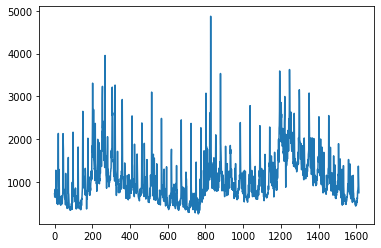

In [13]:
plt.plot(d[5])
plt.show()

Dump the dictionary to a .JSON file.

In [15]:
import json

with open(f'datasets/m4_weekly_dataset.json', 'x') as file:
    json.dump(d, file)

# M3 monthly dataset

In [2]:
with open(f'datasets/m3_monthly_dataset.json', 'r') as file:
    d = json.load(file)

In [3]:
lens = []
min_len = 130
max_len = 9999
for k, v in d.items():
    l = len(v)
    if l >= min_len and l <= max_len:
        lens.append(l)

print(len(lens), np.mean(lens))

799 137.13266583229037


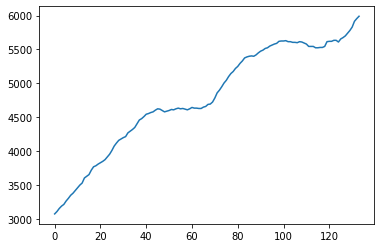

In [4]:
plt.plot(d["822"])
plt.show()

# sklearn Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

ls = d[1]

ls_x, ls_y = data_prep.ts_prep(ls, nlag=3, horizon=1)

rfreg = RandomForestRegressor(
    max_depth=10,
    min_samples_split=0.3,
    min_impurity_decrease=0.0,
    ccp_alpha=0)

rfreg.fit(ls_x[:-5], ls_y[:-5].ravel())


RandomForestRegressor(ccp_alpha=0, max_depth=10, min_samples_split=0.3)

In [36]:
rfreg.predict([ls_x[-1]])[0]

3143.1322882180243

: 

In [8]:
ls = d[1]

ls_x, ls_y = data_prep.ts_prep(ls, nlag=3, horizon=1)

from sklearn.neural_network import MLPRegressor

m = MLPRegressor(hidden_layer_sizes=(10, ))
m.fit(ls_x, ls_y)


/home/yukuan.lin/Desktop/DCTransformation/dclab01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yukuan.lin/Desktop/DCTransformation/dclab01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10,))

In [11]:
import xgboost as xgb

train_ls_x = ls_x[:-5]
train_ls_y = ls_y[:-5]

xgbreg = xgb.XGBRegressor(
    max_depth=5,
    booster='gbtree',
    subsample=0.5
)
xgbreg.fit(X=train_ls_x, y=train_ls_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [12]:
train_ls_y[:3]

array([[1080.],
       [ 840.],
       [1440.]])

In [13]:
train_ls_x[:3]

array([[1680., 1920.,  120.],
       [1920.,  120., 1080.],
       [ 120., 1080.,  840.]])

In [14]:
ls_x[-1]

array([1320., 1320., 2280.])

In [15]:
xgbreg.predict([ls_x[-1]])[0]

1701.307

In [16]:
import lightgbm as lgbm

lgbmreg = lgbm.LGBMRegressor(
    max_depth=5,
    min_split_gain=3,
    importance_type='split'
)

lgbmreg.fit(train_ls_x, train_ls_y.ravel())

LGBMRegressor(max_depth=5, min_split_gain=3)

In [18]:
lgbmreg.predict([ls_x[-1]])[0]

1292.0914116352997

: 

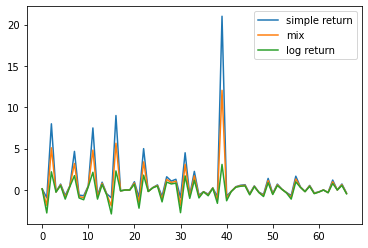

[1.1494989343464272, 3.1882663616451445, 2.0512705205256645]
[ 1.3213478  10.16504239  4.20771075]


In [73]:
def simple_return(ls):
    res = []
    for i, s in enumerate(ls):
        if i == 0: continue
        res.append((s - ls[i-1])/ls[i-1])
    return res

log_return = np.diff(np.log(ls))
simp_return = simple_return(ls)
mix = [np.mean([l, s]) for l, s in zip(log_return, simp_return)]


plt.plot(simp_return, label='simple return')
plt.plot(mix, label='mix')
plt.plot(log_return, label='log return')
plt.legend()
plt.show()
sigma = list(map(np.std, [log_return, simp_return, mix]))
print(sigma)
var = np.square(sigma)
print(var)

In [10]:
import json
import os
"""
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
start = now.strftime("%d-%m-%Y_%H:%M:%S")

isExist = os.path.exists(f'{start}/')

if not isExist:
    os.mkdir(f'{start}/')

d1 = {'1': 1, '2': 2}

with open(f'{start}/d1.json', 'x') as file:
    json.dump(d1, file, indent=4)
"""

In [20]:
l1 = np.array([1, 2])
l2 = np.array([2, 4])
l3 = [0, 0]

import math
math.dist(l1, l2)

2.23606797749979

In [15]:
np.sqrt(5)

2.23606797749979

In [41]:
import itertools

h = {
    '1': [1, 2, 3],
    '2': [(1, ), (1, 2), (1, 2, 3)]
}

tre = [0.1, 0.2, 0.3]

tres = list(itertools.product(tre, tre))

k = [(0.1, 0.2), (0.3, 0.4), (0.5, 0.6)]

nl = [7, 8, 9]

hs = [
    {
        'thres': hkk[0],
        'mhyper 1': hkk[1],
        'mhyper 2': hkk[2],
        'nllll': hkk[3]
    } for hkk in itertools.product(tres, *h.values(), nl)]
pprint(hs)

[{'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1, 2), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1, 2), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper

In [44]:
nl = [{j: i for j in range(3)} for i in range(5)]

b = nl[1]
t = nl[0]

del b[1]
print(b, t)

{0: 1, 2: 1} {0: 0, 1: 0, 2: 0}


In [7]:
print(hs[0])
print(hs[0][0][0], hs[0][0][1])
print(hs[0][1:])

((0.1, 0.1), 1, (1,))
0.1 0.1
(1, (1,))


# validation, test demo

In [4]:
ts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

n_val = 3
n_test = 3
n_lag = 3
h = 1

split = n_val + n_test

for i in range(n_val):
    train_v = ts[:-split+1+i]
    train = train_v[:-h]
    val = train_v[-h:]
    ttrain = [t*0.9 for t in train] # transformation
    # ttrain = train
    tX, ty = data_prep.ts_prep(ttrain, nlag=n_lag, horizon=h)
    ttrainx, tvalx = tX, ttrain[-n_lag:]
    ttrainy, valy = ty, val

    pprint(ttrainx)
    pprint(ttrainy)
    pprint(tvalx)
    pprint(valy)
    print(train)


array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3]])
[4.5, 5.4, 6.3]
[8]
[1, 2, 3, 4, 5, 6, 7]
array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4],
       [4.5, 5.4, 6.3]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3],
       [7.2]])
[5.4, 6.3, 7.2]
[9]
[1, 2, 3, 4, 5, 6, 7, 8]
array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4],
       [4.5, 5.4, 6.3],
       [5.4, 6.3, 7.2]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3],
       [7.2],
       [8.1]])
[6.3, 7.2, 8.1]
[10]
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [13]:
for i in range(n_test):
    if i == n_test-1:
        train = ts
    else:
        train = ts[:-n_test+1+i]

    # ttrain = [t*0.9 for t in train] # transformation
    tX, ty = data_prep.ts_prep(train, nlag=n_lag, horizon=h)
    ttrainx, ttestx = tX[:-1], tX[-1]
    ttrainy, testy = ty[:-1], train[-h]

    pprint(ttrainx)
    pprint(ttrainy)
    pprint(ttestx)
    pprint(testy)
    print(train)

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])
array([ 8,  9, 10])
11
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9, 10]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11]])
array([ 9, 10, 11])
12
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9, 10],
       [ 9, 10, 11]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])
array([10, 11, 12])
13
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [75]:
measure = {'SAPE': lambda y, y_hat: np.abs(y_hat-y)/np.mean((np.abs(y_hat), np.abs(y)))}

k = np.array([10])[0]
measure['SAPE'](9, k)

0.10526315789473684